In [1]:
#Import Library
import os
import shutil
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


In [37]:
# Source directory containing subdirectories for each class
source = 'dataset/'

# Get a list of all files (subdirectories) in the source directory
all_files = os.listdir(source)

# Iterate through each subdirectory (class) in the source directory
for class_name in all_files:
    # Get a list of files (images) in the current class directory
    files = os.listdir(os.path.join(source, class_name))
    
    # Print the class name and the number of images in that class
    print(f"{class_name}: {len(files)} images")


batik-cendrawasih : 146 images
batik-dayak : 115 images
batik-kawung : 152 images
batik-lasem : 154 images
batik-megamendung : 118 images
batik-parang : 166 images
batik-pring-sedapur : 157 images
batik-sekar : 107 images
batik-tambal : 122 images
batik-tuntrum : 110 images


In [38]:
# Source directory containing subdirectories for each class
source = 'dataset/'

# Target directories for the train and validation sets
train_dir = 'dataset_split/train'
val_dir = 'dataset_split/val'

# Split ratio for validation set
val_split = 0.2

# Get a list of all files (subdirectories) in the source directory
all_files = os.listdir(source)

# Iterate through each subdirectory (class) in the source directory
for class_name in all_files:
    # Create directories for train and validation sets for the current class
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Get a list of files (images) in the current class directory
    files = os.listdir(os.path.join(source, class_name))

    # Split files into train and validation sets
    train_files, val_files = train_test_split(files, test_size=val_split, random_state=50)

    # Copy files to the train set directory
    for file in train_files:
        source_path = os.path.join(source, class_name, file)
        des_path = os.path.join(train_dir, class_name, file)

        try:
            # Verify and copy the image
            with Image.open(source_path) as img:
                img.verify()
                shutil.copy(source_path, des_path)
        except (IOError, SyntaxError) as e:
            print(f"Unable to open {file}: {e}")

    # Copy files to the validation set directory
    for file in val_files:
        source_path = os.path.join(source, class_name, file)
        des_path = os.path.join(val_dir, class_name, file)

        try:
            # Verify and copy the image
            with Image.open(source_path) as img:
                img.verify()
                shutil.copy(source_path, des_path)
        except (IOError, SyntaxError) as e:
            print(f"Unable to open {file}: {e}")

In [39]:
# Iterate through each class in the training directory and print the number of images
for file in all_files:
    img_path = os.path.join(train_dir, file)
    file_list = os.listdir(img_path)
    print(f"train {file}: {len(file_list)} images")

# Iterate through each class in the validation directory and print the number of images
for file in all_files:
    img_path = os.path.join(val_dir, file)
    file_list = os.listdir(img_path)
    print(f"validation {file}: {len(file_list)} images")

train batik-cendrawasih  : 116 images
train batik-dayak  : 92 images
train batik-kawung  : 121 images
train batik-lasem  : 123 images
train batik-megamendung  : 94 images
train batik-parang  : 132 images
train batik-pring-sedapur  : 125 images
train batik-sekar  : 85 images
train batik-tambal  : 97 images
train batik-tuntrum  : 88 images
validation batik-cendrawasih : 30 images
validation batik-dayak : 23 images
validation batik-kawung : 31 images
validation batik-lasem : 31 images
validation batik-megamendung : 24 images
validation batik-parang : 34 images
validation batik-pring-sedapur : 32 images
validation batik-sekar : 22 images
validation batik-tambal : 25 images
validation batik-tuntrum : 22 images


In [2]:
# Image dimensions for preprocessing
img_width = 224;
img_height = 224;

In [41]:
# ImageDataGenerator for training set augmentation
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    directory = train_dir,
    batch_size = 16,
    class_mode = 'categorical',
    target_size = (img_width,img_height)
)

# ImageDataGenerator for validation set (no augmentation)
val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_gen = val_datagen.flow_from_directory(
    directory = val_dir,
    batch_size = 4,
    class_mode = 'categorical',
    target_size = (img_width,img_height)
)


Found 987 images belonging to 10 classes.
Found 258 images belonging to 10 classes.


In [10]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if validation accuracy exceeds 90%
        if logs.get('val_accuracy') > 0.9:
            print("\nVal akurasi mencapai lebih dari 90%, training dihentikan.")
            self.model.stop_training = True

In [11]:
# Define the base model (MobileNetV2) with specified input shape and pre-trained weights
base_model = MobileNetV2(input_shape = (img_width,img_height,3),
                     include_top = False,
                     weights = 'imagenet')    

# Freeze the weights of the layers in the base model
for layer in base_model.layers:
    layer.trainable = False


# Build the custom model architecture on top of the base model
x = tf.keras.layers.Conv2D(128, (3,3), padding = 'same', activation='relu')(base_model.output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu', name='feature_extract_layer')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the final model by specifying input and output layers
model = tf.keras.Model(base_model.input, x)

# Compile the model with RMSprop optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
            loss=tf.keras.losses.categorical_crossentropy,
            metrics=['accuracy'])

# Display the model summary
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [12]:
# Instantiate the custom callback
callback = MyCallback()


# Train the model using the fit method
history = model.fit(
    train_gen,
    epochs = 100,
    verbose = 1,
    validation_data = val_gen,
    callbacks=[callback]
)

Epoch 1/100


62/62 [==============================] - 66s 960ms/step - loss: 2.5826 - accuracy: 0.2333 - val_loss: 1.3216 - val_accuracy: 0.5736
Epoch 2/100
62/62 [==============================] - 52s 840ms/step - loss: 1.5079 - accuracy: 0.5030 - val_loss: 1.1291 - val_accuracy: 0.6357
Epoch 3/100
62/62 [==============================] - 60s 963ms/step - loss: 1.1332 - accuracy: 0.6293 - val_loss: 0.7664 - val_accuracy: 0.7674
Epoch 4/100
62/62 [==============================] - 61s 974ms/step - loss: 0.9334 - accuracy: 0.7131 - val_loss: 0.7222 - val_accuracy: 0.7713
Epoch 5/100
62/62 [==============================] - 60s 962ms/step - loss: 0.8194 - accuracy: 0.7515 - val_loss: 0.7408 - val_accuracy: 0.7868
Epoch 6/100
62/62 [==============================] - 58s 925ms/step - loss: 0.7206 - accuracy: 0.7818 - val_loss: 0.7192 - val_accuracy: 0.8101
Epoch 7/100
62/62 [==============================] - 60s 976ms/step - loss: 0.6919 - accuracy: 0.8010 - val_loss: 0.6261 - val_accurac

In [ ]:
# Save the entire model to a file in HDF5 format
model.save("model.h5")

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


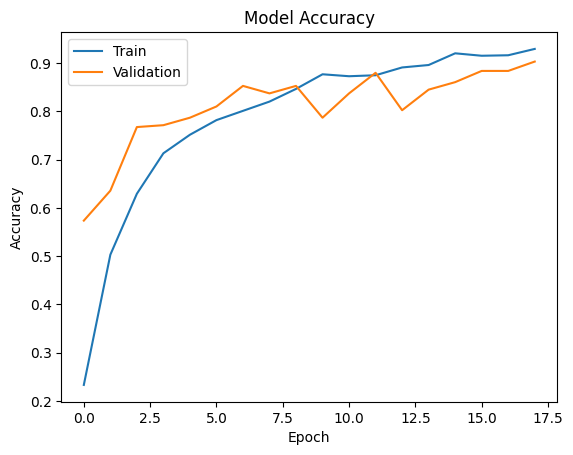

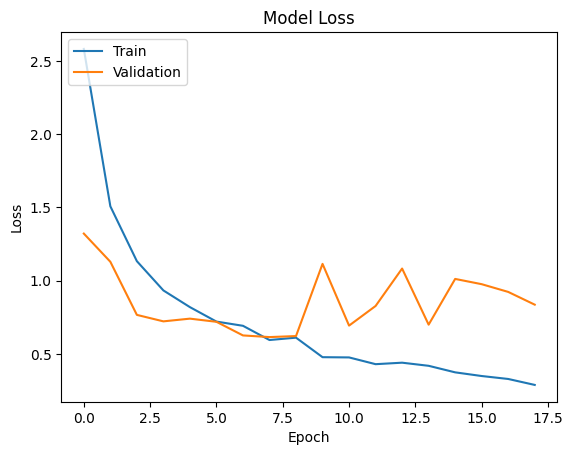

In [15]:
# Extract training history from the 'history' object
history = history.history

# Plotting model accuracy over epochs
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting model loss over epochs
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [6]:
from tensorflow.keras.preprocessing import image

def load_and_process_image(image_path):
    # Load the image and resize it to the target size
    img = image.load_img(image_path, target_size=(img_width, img_height))
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Add an extra dimension to the array to represent the batch size (1 in this case)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for the model
    img_array = preprocess_input(img_array)
    
    return img_array

In [3]:
# Load the saved model from the HDF5 file
motif_batik_model = tf.keras.models.load_model('model.h5')

# Create a feature extraction model using the desired layer as output
feature_extractor = tf.keras.Model(inputs=motif_batik_model.input, outputs=motif_batik_model.get_layer('feature_extract_layer').output)

In [63]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [4]:
# Directory containing recommendation images
recomendation_dir = 'rekomendasi'

# List to store image paths
list_image_path = []

# List all motifs in the recommendation directory
list_motif = os.listdir(recomendation_dir)

# Loop through each motif
for motif in list_motif:
    # List all images in the current motif directory
    images = os.listdir(os.path.join(recomendation_dir, motif))
    
    # Loop through each image in the motif
    for image in images:
        # Construct the image path
        image_path = os.path.join(motif, image)
        
        # Replace backslashes with forward slashes in the image path
        image_path = image_path.replace("\\", "/")
        
        # Append the image path to the list
        list_image_path.append(image_path)

# Print the shape and list of image paths
print(np.shape(list_image_path))
print(list_image_path)
    

(901,)
['batik-cendrawasih/batik-cendrawasih-1.jpg', 'batik-cendrawasih/batik-cendrawasih-10.jpg', 'batik-cendrawasih/batik-cendrawasih-11.jpg', 'batik-cendrawasih/batik-cendrawasih-12.jpg', 'batik-cendrawasih/batik-cendrawasih-13.jpg', 'batik-cendrawasih/batik-cendrawasih-14.jpg', 'batik-cendrawasih/batik-cendrawasih-15.jpg', 'batik-cendrawasih/batik-cendrawasih-16.jpg', 'batik-cendrawasih/batik-cendrawasih-17.jpg', 'batik-cendrawasih/batik-cendrawasih-18.jpg', 'batik-cendrawasih/batik-cendrawasih-19.jpg', 'batik-cendrawasih/batik-cendrawasih-2.jpg', 'batik-cendrawasih/batik-cendrawasih-20.jpg', 'batik-cendrawasih/batik-cendrawasih-21.jpg', 'batik-cendrawasih/batik-cendrawasih-22.jpg', 'batik-cendrawasih/batik-cendrawasih-23.jpg', 'batik-cendrawasih/batik-cendrawasih-24.jpg', 'batik-cendrawasih/batik-cendrawasih-25.jpg', 'batik-cendrawasih/batik-cendrawasih-26.jpg', 'batik-cendrawasih/batik-cendrawasih-27.jpg', 'batik-cendrawasih/batik-cendrawasih-28.jpg', 'batik-cendrawasih/batik-cen

In [7]:
imported_images = []

# Loop through each image path in the list
for image_path in list_image_path:
    # Construct the full image path
    image_path = os.path.join(recomendation_dir, image_path)
    
    # Load and preprocess the image using the load_and_process_image function
    imported_image = load_and_process_image(image_path)
    
    # Append the preprocessed image to the list
    imported_images.append(imported_image)

In [8]:
# Convert the list of preprocessed images to a numpy array
list_images = np.vstack(imported_images)

# Use the feature extractor to obtain features for the images
images_features = feature_extractor.predict(list_images)

# Print the shape of the extracted features
print(np.shape(images_features))

29/29 [==============================] - 34s 880ms/step


(901, 128)

In [58]:
# Save the image features to a joblib file
joblib.dump(images_features, 'image_features.joblib')

# Save the list of image paths to a joblib file
joblib.dump(list_image_path, 'image_paths.joblib')

['image_paths.joblib']

In [ ]:
nb_closest_images =5
def retrieve_most_similar_batik1(given_img_path):
     # Load and preprocess the target image
    target_image = load_and_process_image(given_img_path)

    # Extract features for the target image
    target_features = feature_extractor.predict(target_image)

    print("-----------------------------------------------------------------------")
    print("Original Image:")
    original = image.load_img(given_img_path, target_size=(int(img_width), int(img_height)))
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(original)
    plt.axis('off')
    plt.show()
    print("-----------------------------------------------------------------------")
    print("Most Similar Images (Cosine Similarities):")
    
    # Find most similar images using cosine similarities
    similarities = cosine_similarity(target_features, images_features)
    target_image_index = 0
    recommended_images = np.argsort(similarities[target_image_index])[::-1][:nb_closest_images]

    # Plot the most similar images in a subplot
    rows = 1
    cols = nb_closest_images
    plt.figure(figsize=(15, 5))  # Sesuaikan ukuran total subplot

    for i, index in enumerate(recommended_images):
        image_path = list_image_path[index]
        similarity_score = similarities[target_image_index][index]

        # Membuat subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image.load_img(os.path.join(recomendation_dir, image_path), target_size=(img_width, img_height)))
        plt.title(f"Similarity: {similarity_score:.4f}")
        plt.axis('off')

    plt.show()

In [64]:
test_path = "test";
list_test_path = [];
list_test = os.listdir(test_path);
for i, test in enumerate(list_test):
    list_test_path.append(os.path.join(test_path, test));
    print(f"{i}  - {test}")
    

0  - test-cendrawasih-1.png
1  - test-dayak-1.png
2  - test-dayak-2.png
3  - test-kawung-1.jpg
4  - test-kawung-3.png
5  - test-kawung-4.png
6  - test-kawung-5.png
7  - test-kawung-6.png
8  - test-lasem-1.jpg
9  - test-megamendung-1.png
10  - test-megamendung-2.png
11  - test-parang-1.jfif
12  - test-parang-2.png
13  - test-parang-3.jfif
14  - test-pringsedapur-1.jpg
15  - test-sekar-1.png
16  - test-sekar-2.jpg
17  - test-sekar-2.png
18  - test-sekar-3.png
19  - test-tambal-1.jpg


1/1 [==============================] - 0s 104ms/step
-----------------------------------------------------------------------
Original Image:


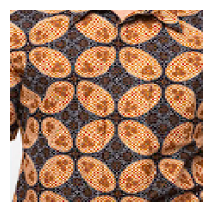

-----------------------------------------------------------------------
Most Similar Images (Cosine Similarities):


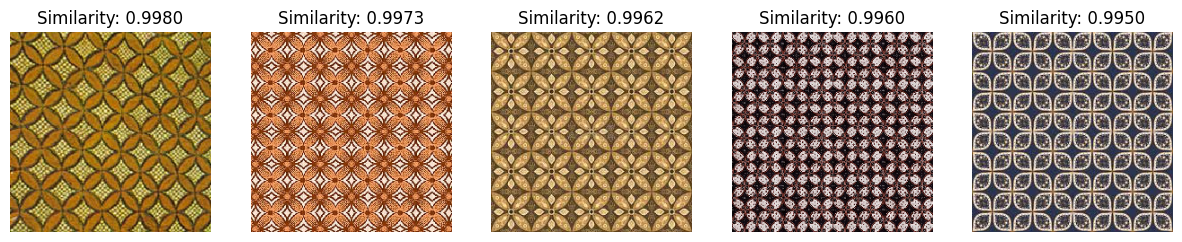

In [66]:
retrieve_most_similar_batik1(list_test_path[5])